# Federated Learning with SAM2LoRA: Heterogeneous Clients

This notebook demonstrates federated learning for medical image segmentation using the full **SAM2LoRA** model from `task.py`.

## Setup
- **4 Data Owners (DOs)** with different capabilities:
  - DO 1: Zero-shot (CLIP-based, no training)
  - DO 2: Few-shot (memory bank, no gradient training)
  - DO 3: LoRA adapter training
  - DO 4: LoRA adapter training
- **Dataset**: Chest CT Segmentation (113 patients, 16K+ slices)
- **Aggregation**: FedAvg on LoRA weights only (DO 3 & 4 contribute)

In [ ]:
# Check dependencies
try:
    import accelerate
    print(f"✓ accelerate: {accelerate.__version__}")
except ImportError:
    print("⚠ accelerate not found. Run: pip install --no-deps accelerate")

In [1]:
# Cell 1: Imports and Setup
import sys
from pathlib import Path

# Project paths
PROJECT_ROOT = Path("/Users/edwin/Desktop/Business/Technological/fl-sam2-lora")
TASK_MODULE_PATH = PROJECT_ROOT / "fl-sam2-lora" / "fl-sam2-lora"
SAM2_LIB_PATH = PROJECT_ROOT / "segment-anything-2"

# Add to path for imports
sys.path.insert(0, str(TASK_MODULE_PATH))
sys.path.insert(0, str(SAM2_LIB_PATH))

import torch
import torch.nn.functional as F  # Added for training functions
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy
from PIL import Image
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.2.2
Device: mps


In [2]:
# Cell 2: Import SAM2LoRA from task.py
# The module folder has hyphens, so we use importlib
import importlib.util
from pathlib import Path

# Load task.py directly
task_path = Path("/Users/edwin/Desktop/Business/Technological/fl-sam2-lora/fl-sam2-lora/fl-sam2-lora/task.py")
spec = importlib.util.spec_from_file_location("task", task_path)
task = importlib.util.module_from_spec(spec)
spec.loader.exec_module(task)

# Import what we need
SAM2LoRA = task.SAM2LoRA
create_model = task.create_model
train = task.train
evaluate = task.evaluate
get_weights = task.get_weights
set_weights = task.set_weights
DEFAULT_SAM2_CHECKPOINT = task.DEFAULT_SAM2_CHECKPOINT
DEFAULT_SAM2_CONFIG = task.DEFAULT_SAM2_CONFIG

print(f"SAM2 Checkpoint: {DEFAULT_SAM2_CHECKPOINT}")
print(f"SAM2 Config: {DEFAULT_SAM2_CONFIG}")
print(f"Checkpoint exists: {Path(DEFAULT_SAM2_CHECKPOINT).exists()}")

ModuleNotFoundError: No module named 'accelerate'

In [3]:
# Cell 3: Configuration

# Paths
DATASET_PATH = PROJECT_ROOT / "dataset" / "chest-ct-segmentation"

# Device
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

# FL Config
NUM_ROUNDS = 3
LOCAL_EPOCHS = 5  # Updated from 2 to 5 for better LoRA adaptation
LEARNING_RATE = 5e-5  # Updated from 1e-4 to 5e-5 for more stable training
LORA_RANK = 8
IMG_SIZE = 1024  # SAM2 default
MODALITY = "ct"
BATCH_SIZE = 1
USE_CLIP = True

# DO Config
SAMPLES_PER_DO = 20  # Samples per DO for demo
TEST_SAMPLES_PER_DO = 5
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"Dataset path: {DATASET_PATH}")
print(f"Dataset exists: {DATASET_PATH.exists()}")
print(f"Device: {DEVICE}")

Dataset path: /Users/edwin/Desktop/Business/Technological/fl-sam2-lora/dataset/chest-ct-segmentation
Dataset exists: True
Device: mps


In [4]:
# Cell 4: Dataset Class for Chest CT Segmentation

class ChestCTDataset(Dataset):
    """
    Dataset for Chest CT Segmentation.
    
    Handles the nested directory structure:
    - images/images/*.jpg
    - masks/masks/*.jpg (RGB masks where any non-zero pixel is foreground)
    """
    
    def __init__(
        self,
        data_dir: Path,
        image_ids: List[str],
        mask_ids: List[str],
        target_size: int = 1024,
        modality: str = "ct"
    ):
        self.data_dir = Path(data_dir)
        self.images_dir = self.data_dir / "images" / "images"
        self.masks_dir = self.data_dir / "masks" / "masks"
        self.image_ids = image_ids
        self.mask_ids = mask_ids
        self.target_size = target_size
        self.modality = modality
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.images_dir / self.image_ids[idx]
        image = Image.open(img_path).convert("RGB")
        image = image.resize((self.target_size, self.target_size), Image.BILINEAR)
        image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255.0
        
        # Load mask - RGB mask where any non-zero channel indicates foreground
        mask_path = self.masks_dir / self.mask_ids[idx]
        mask = Image.open(mask_path)
        mask = mask.resize((self.target_size, self.target_size), Image.NEAREST)
        mask_arr = np.array(mask)
        
        # Convert RGB mask to binary: any channel > 0 means foreground
        if len(mask_arr.shape) == 3:
            # Take max across channels - any non-zero channel is foreground
            binary_mask = (mask_arr.max(axis=2) > 0).astype(np.float32)
        else:
            binary_mask = (mask_arr > 0).astype(np.float32)
        
        mask = torch.tensor(binary_mask, dtype=torch.float32)
        
        return {
            "image": image,
            "mask": mask.unsqueeze(0),  # [1, H, W]
            "path": str(img_path),
            "modality": self.modality,
        }

print("ChestCTDataset class defined.")

# Quick test
test_ds = ChestCTDataset(
    data_dir=DATASET_PATH,
    image_ids=["ID00007637202177411956430_0.jpg"],
    mask_ids=["ID00007637202177411956430_mask_0.jpg"],
    target_size=512,
)
sample = test_ds[0]
print(f"Image shape: {sample['image'].shape}")
print(f"Mask shape: {sample['mask'].shape}")
print(f"Mask unique values: {torch.unique(sample['mask'])}")
print(f"Mask foreground pixels: {(sample['mask'] > 0).sum().item()}")

ChestCTDataset class defined.
Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([1, 512, 512])
Mask unique values: tensor([0., 1.])
Mask foreground pixels: 3388


In [5]:
# Cell 5: Load and Split Dataset by Patient
# 
# DO allocation based on data availability:
# - DO 1 (Zero-shot): NO labeled data - uses CLIP text prompts only
# - DO 2 (Few-shot): 1-5 labeled images - uses memory bank
# - DO 3 (LoRA): >10 labeled images - full training
# - DO 4 (LoRA): >10 labeled images - full training

# Read train.csv
train_df = pd.read_csv(DATASET_PATH / "train.csv")
print(f"Total samples in dataset: {len(train_df)}")

# Extract patient IDs from image names
train_df['patient_id'] = train_df['ImageId'].str.rsplit('_', n=1).str[0]
patient_ids = train_df['patient_id'].unique()
print(f"Unique patients: {len(patient_ids)}")

# Shuffle patients
np.random.shuffle(patient_ids)

# Split patients: 0 for zero-shot, few for few-shot, rest split between LoRA DOs
# Zero-shot gets NO patients (no data)
# Few-shot gets 1 patient (for ~5 images)
# LoRA DOs split the remaining patients

fewshot_patients = patient_ids[0:1]  # 1 patient for few-shot
lora_patients = patient_ids[1:]  # Rest for LoRA training
lora_split = len(lora_patients) // 2

do_patient_splits = {
    "DO_1_zeroshot": np.array([]),  # NO DATA - zero-shot only
    "DO_2_fewshot": fewshot_patients,  # 1 patient (~5 images)
    "DO_3_lora": lora_patients[:lora_split],
    "DO_4_lora": lora_patients[lora_split:],
}

print("\nData Owner Allocation:")
print("-" * 50)
for do_name, patients in do_patient_splits.items():
    if len(patients) == 0:
        print(f"{do_name}: 0 patients, 0 samples (text prompts only)")
    else:
        num_samples = len(train_df[train_df['patient_id'].isin(patients)])
        print(f"{do_name}: {len(patients)} patients, {num_samples} samples")

Total samples in dataset: 16708
Unique patients: 112

Data Owner Allocation:
--------------------------------------------------
DO_1_zeroshot: 0 patients, 0 samples (text prompts only)
DO_2_fewshot: 1 patients, 210 samples
DO_3_lora: 55 patients, 9321 samples
DO_4_lora: 56 patients, 7177 samples


In [6]:
# Cell 6: Create DataLoaders for Each DO
#
# Data allocation:
# - DO 1 (Zero-shot): 0 samples (text prompts only)
# - DO 2 (Few-shot): 4 labeled images
# - DO 3 (LoRA): 16 labeled images
# - DO 4 (LoRA): 14 labeled images

def create_do_dataloaders(
    patient_ids: np.ndarray,
    train_df: pd.DataFrame,
    data_dir: Path,
    train_samples: int = 20,
    test_samples: int = 5,
    target_size: int = 1024,
    batch_size: int = 1
) -> Tuple[DataLoader, DataLoader]:
    """
    Create train and test dataloaders for a specific DO's patients.
    Returns (None, None) if no patients provided.
    """
    if len(patient_ids) == 0:
        return None, None
    
    # Filter samples for this DO's patients
    do_df = train_df[train_df['patient_id'].isin(patient_ids)].copy()
    do_df = do_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    # Limit samples
    total_samples = min(len(do_df), train_samples + test_samples)
    do_df = do_df.head(total_samples)
    
    # Split into train/test
    split_idx = min(train_samples, len(do_df) - test_samples)
    split_idx = max(1, split_idx)  # At least 1 for train
    train_df_do = do_df.head(split_idx)
    test_df_do = do_df.tail(min(test_samples, len(do_df) - split_idx))
    
    # Create datasets
    train_dataset = ChestCTDataset(
        data_dir=data_dir,
        image_ids=train_df_do['ImageId'].tolist(),
        mask_ids=train_df_do['MaskId'].tolist(),
        target_size=target_size,
    )
    
    test_dataset = ChestCTDataset(
        data_dir=data_dir,
        image_ids=test_df_do['ImageId'].tolist(),
        mask_ids=test_df_do['MaskId'].tolist(),
        target_size=target_size,
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# DO-specific sample counts
DO_SAMPLE_CONFIG = {
    "DO_1_zeroshot": {"train": 0, "test": 0},
    "DO_2_fewshot": {"train": 4, "test": 2},
    "DO_3_lora": {"train": 16, "test": 4},
    "DO_4_lora": {"train": 14, "test": 4},
}

# Create dataloaders for all DOs
do_dataloaders = {}
print("DataLoader Creation:")
print("-" * 50)

for do_name, patients in do_patient_splits.items():
    config = DO_SAMPLE_CONFIG[do_name]
    
    if config["train"] == 0:
        # Zero-shot: no data
        do_dataloaders[do_name] = {"train": None, "test": None}
        print(f"{do_name}: No data (zero-shot uses text prompts)")
    else:
        train_loader, test_loader = create_do_dataloaders(
            patient_ids=patients,
            train_df=train_df,
            data_dir=DATASET_PATH,
            train_samples=config["train"],
            test_samples=config["test"],
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
        )
        do_dataloaders[do_name] = {"train": train_loader, "test": test_loader}
        train_count = len(train_loader.dataset) if train_loader else 0
        test_count = len(test_loader.dataset) if test_loader else 0
        print(f"{do_name}: Train={train_count}, Test={test_count}")

# Create global test loader (from LoRA DOs only)
lora_patients = np.concatenate([do_patient_splits["DO_3_lora"], do_patient_splits["DO_4_lora"]])
_, global_test_loader = create_do_dataloaders(
    patient_ids=lora_patients,
    train_df=train_df,
    data_dir=DATASET_PATH,
    train_samples=0,
    test_samples=10,
    target_size=IMG_SIZE,
)
print(f"\nGlobal test set: {len(global_test_loader.dataset)} samples")

DataLoader Creation:
--------------------------------------------------
DO_1_zeroshot: No data (zero-shot uses text prompts)
DO_2_fewshot: Train=4, Test=2
DO_3_lora: Train=16, Test=4
DO_4_lora: Train=14, Test=4

Global test set: 9 samples


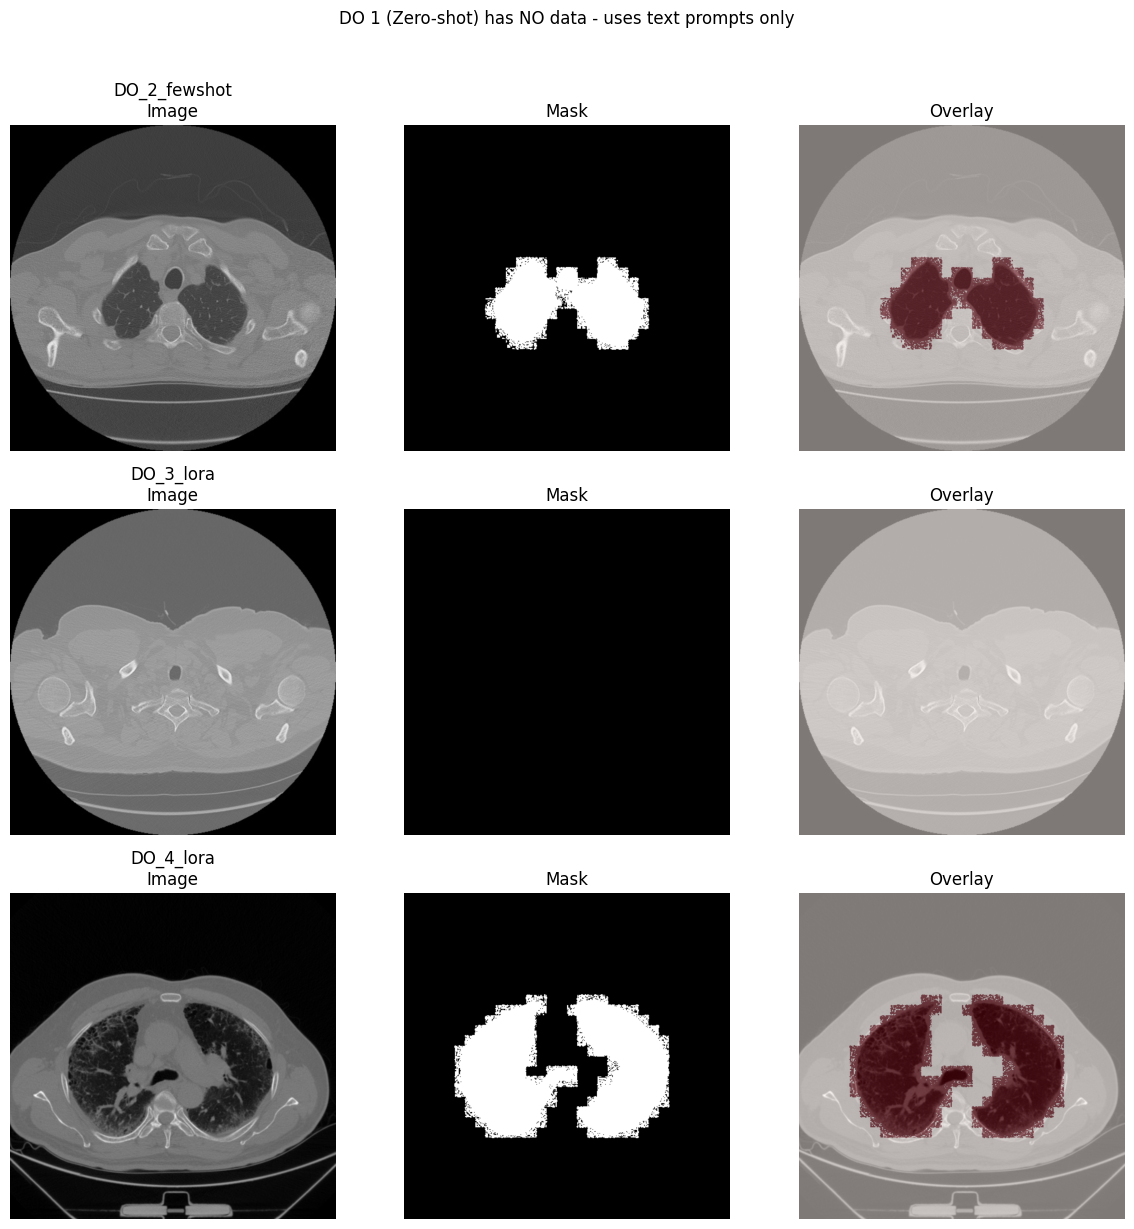

In [7]:
# Cell 7: Visualize Sample Data (only for DOs with data)

# Count DOs with data
dos_with_data = [(name, loaders) for name, loaders in do_dataloaders.items() if loaders["train"] is not None]

fig, axes = plt.subplots(len(dos_with_data), 3, figsize=(12, 4 * len(dos_with_data)))

for idx, (do_name, loaders) in enumerate(dos_with_data):
    sample = next(iter(loaders["train"]))
    image = sample["image"][0].permute(1, 2, 0).numpy()
    mask = sample["mask"][0, 0].numpy()
    
    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title(f"{do_name}\nImage")
    axes[idx, 0].axis("off")
    
    axes[idx, 1].imshow(mask, cmap="gray")
    axes[idx, 1].set_title("Mask")
    axes[idx, 1].axis("off")
    
    axes[idx, 2].imshow(image)
    axes[idx, 2].imshow(mask, alpha=0.5, cmap="Reds")
    axes[idx, 2].set_title("Overlay")
    axes[idx, 2].axis("off")

plt.suptitle("DO 1 (Zero-shot) has NO data - uses text prompts only", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

In [8]:
# Cell 8: Verify Model Creation Works

print("Testing model creation...")
print(f"  - SAM2 Checkpoint: {DEFAULT_SAM2_CHECKPOINT}")
print(f"  - SAM2 Config: {DEFAULT_SAM2_CONFIG}")
print(f"  - LoRA Rank: {LORA_RANK}")
print(f"  - Use CLIP: {USE_CLIP}")
print(f"  - Image Size: {IMG_SIZE}")

test_model = create_model(
    sam2_checkpoint=str(DEFAULT_SAM2_CHECKPOINT),
    sam2_config=DEFAULT_SAM2_CONFIG,
    img_size=IMG_SIZE,
    lora_rank=LORA_RANK,
    use_clip=USE_CLIP,
)

# Verify LoRA parameters are trainable
trainable_params = [p for p in test_model.parameters() if p.requires_grad]
print(f"\nTrainable parameters: {len(trainable_params)}")
print(f"Total trainable params: {sum(p.numel() for p in trainable_params):,}")

del test_model
print("\nModel creation verified successfully!")

2025-12-11 21:43:32.727 | INFO     | task:__init__:117 - Loading SAM-2 from /Users/edwin/Desktop/Business/Technological/fl-sam2-lora/models/pretrained/sam2_hiera_tiny.pt...


Testing model creation...
  - SAM2 Checkpoint: /Users/edwin/Desktop/Business/Technological/fl-sam2-lora/models/pretrained/sam2_hiera_tiny.pt
  - SAM2 Config: sam2_hiera_t.yaml
  - LoRA Rank: 8
  - Use CLIP: True
  - Image Size: 1024


2025-12-11 21:43:34.289 | INFO     | task:_init_sam2:150 - ✓ Loaded SAM2 using sam2 package
2025-12-11 21:43:34.291 | INFO     | task:__init__:124 - ✓ Froze SAM-2 backbone
2025-12-11 21:43:34.291 | INFO     | task:_apply_lora:154 - Adding LoRA adapters (r=8)...
2025-12-11 21:43:34.326 | INFO     | task:_apply_lora:176 - ✓ LoRA adapters: 238,488 params (0.91 MB)
2025-12-11 21:43:34.334 | INFO     | task:_init_clip:180 - Loading CLIP for zero-shot and few-shot...
2025-12-11 21:43:43.879 | INFO     | task:_init_clip:186 - ✓ CLIP loaded
2025-12-11 21:43:43.883 | INFO     | task:_init_training_decoder:201 - ✓ Using SAM2's native mask decoder for training (differentiable)
2025-12-11 21:43:43.895 | INFO     | task:print_trainable_parameters:1047 - Trainable: 238,488 (0.91 MB) | Total: 190,461,787 | Trainable %: 0.1252%



Trainable parameters: 56
Total trainable params: 238,488

Model creation verified successfully!


In [9]:
# Cell 9: FedAvg Aggregation Function

def fedavg_aggregate(
    weight_lists: List[List[np.ndarray]],
    sample_counts: List[int]
) -> List[np.ndarray]:
    """
    Federated Averaging of LoRA adapter weights.
    
    Args:
        weight_lists: List of weight lists from each client (from get_weights())
        sample_counts: Number of samples each client trained on
    
    Returns:
        Aggregated weights as list of numpy arrays
    """
    if not weight_lists:
        return []
    
    # Compute weights based on sample counts
    total_samples = sum(sample_counts)
    client_weights = [count / total_samples for count in sample_counts]
    
    # Weighted average of each parameter
    aggregated = []
    num_params = len(weight_lists[0])
    
    for param_idx in range(num_params):
        weighted_sum = sum(
            weights[param_idx] * client_weight
            for weights, client_weight in zip(weight_lists, client_weights)
        )
        aggregated.append(weighted_sum)
    
    return aggregated

print("FedAvg aggregation function defined.")

FedAvg aggregation function defined.


In [10]:
# Cell 10: Client Training Function (using SAM2LoRA.adaptive_fit)
#
# The adaptive_fit method in SAM2LoRA automatically selects:
# - 0 samples → Zero-shot (CLIP text prompts)
# - 1-5 samples → Few-shot (memory bank)
# - >5 samples → LoRA training

def train_client_adaptive(
    global_weights: List[np.ndarray],
    train_loader: DataLoader,
    test_loader: DataLoader,
    local_epochs: int = 2,
    learning_rate: float = 1e-4,
    few_shot_threshold: int = 5,
) -> Tuple[List[np.ndarray], Dict]:
    """
    Train a client using SAM2LoRA's adaptive_fit method.
    
    Automatically selects zero-shot, few-shot, or LoRA based on data availability.
    """
    # Create fresh model
    model = create_model(
        sam2_checkpoint=str(DEFAULT_SAM2_CHECKPOINT),
        sam2_config=DEFAULT_SAM2_CONFIG,
        img_size=IMG_SIZE,
        lora_rank=LORA_RANK,
        use_clip=USE_CLIP,
    )
    
    # Load global weights if provided (for LoRA continuity)
    if global_weights is not None:
        set_weights(model, global_weights)
    
    # Use adaptive_fit - it will automatically select the method
    result = model.adaptive_fit(
        train_loader=train_loader,
        test_loader=test_loader,
        modality=MODALITY,
        class_name="target",
        local_epochs=local_epochs,
        learning_rate=learning_rate,
        few_shot_threshold=few_shot_threshold,
    )
    
    del model
    
    return result['weights'], {
        'method': result['method'],
        'dice': result['metrics']['dice'],
        'loss': result['metrics']['loss'],
        'history': result.get('history'),
        'num_samples': result['num_samples'],
    }

print("Client training function defined (using SAM2LoRA.adaptive_fit).")

Client training function defined (using SAM2LoRA.adaptive_fit).


In [11]:
# Cell 11: Initial Evaluation (before FL training)

print("Evaluating initial model (before FL training)...")
init_model = create_model(
    sam2_checkpoint=str(DEFAULT_SAM2_CHECKPOINT),
    sam2_config=DEFAULT_SAM2_CONFIG,
    img_size=IMG_SIZE,
    lora_rank=LORA_RANK,
    use_clip=USE_CLIP,
)

init_loss, init_dice = evaluate(init_model, global_test_loader)
print(f"Initial Model - Loss: {init_loss:.4f}, Dice: {init_dice:.4f}")

del init_model

2025-12-11 21:44:09.868 | INFO     | task:__init__:117 - Loading SAM-2 from /Users/edwin/Desktop/Business/Technological/fl-sam2-lora/models/pretrained/sam2_hiera_tiny.pt...


Evaluating initial model (before FL training)...


2025-12-11 21:44:12.445 | INFO     | task:_init_sam2:150 - ✓ Loaded SAM2 using sam2 package
2025-12-11 21:44:12.448 | INFO     | task:__init__:124 - ✓ Froze SAM-2 backbone
2025-12-11 21:44:12.448 | INFO     | task:_apply_lora:154 - Adding LoRA adapters (r=8)...
2025-12-11 21:44:12.508 | INFO     | task:_apply_lora:176 - ✓ LoRA adapters: 238,488 params (0.91 MB)
2025-12-11 21:44:12.508 | INFO     | task:_init_clip:180 - Loading CLIP for zero-shot and few-shot...
2025-12-11 21:44:21.858 | INFO     | task:_init_clip:186 - ✓ CLIP loaded
2025-12-11 21:44:21.866 | INFO     | task:_init_training_decoder:201 - ✓ Using SAM2's native mask decoder for training (differentiable)
2025-12-11 21:44:21.906 | INFO     | task:print_trainable_parameters:1047 - Trainable: 238,488 (0.91 MB) | Total: 190,461,787 | Trainable %: 0.1252%


Initial Model - Loss: 32.8680, Dice: 0.1904


In [ ]:
# Cell 12: Federated Learning Loop (using adaptive_fit)
#
# Each DO calls model.adaptive_fit() which automatically selects:
# - 0 samples → Zero-shot
# - 1-5 samples → Few-shot  
# - >5 samples → LoRA training
#
# Only LoRA clients contribute weights to FedAvg aggregation.

# History tracking
fl_history = {
    "global_loss": [],
    "global_dice": [],
    "round_metrics": [],
}

# Global weights (None for first round)
global_weights = None

print(f"\n{'='*80}")
print(f"FEDERATED LEARNING WITH SAM2LoRA (Adaptive Training)")
print(f"Rounds: {NUM_ROUNDS} | Local Epochs: {LOCAL_EPOCHS} | LR: {LEARNING_RATE}")
print(f"{'='*80}")
print(f"\nAdaptive Training Selection:")
print(f"  - 0 samples → Zero-shot (CLIP text prompts)")
print(f"  - 1-5 samples → Few-shot (memory bank)")
print(f"  - >5 samples → LoRA fine-tuning")
print(f"{'='*80}")

# DO names for iteration
do_names = list(do_dataloaders.keys())

for round_num in range(1, NUM_ROUNDS + 1):
    print(f"\n{'#'*80}")
    print(f"ROUND {round_num}/{NUM_ROUNDS}")
    print(f"{'#'*80}")
    
    round_weights = []
    round_sample_counts = []
    round_metrics = {}
    
    for do_name in do_names:
        print(f"\n--- {do_name} ---")
        
        train_loader = do_dataloaders[do_name]["train"]
        test_loader = do_dataloaders[do_name]["test"]
        
        # Use adaptive training - method is selected automatically
        weights, metrics = train_client_adaptive(
            global_weights=global_weights,
            train_loader=train_loader,
            test_loader=test_loader if test_loader else global_test_loader,
            local_epochs=LOCAL_EPOCHS,
            learning_rate=LEARNING_RATE,
            few_shot_threshold=5,
        )
        
        print(f"  Method: {metrics['method'].upper()}")
        print(f"  Samples: {metrics['num_samples']}")
        print(f"  Dice: {metrics['dice']:.4f}")
        
        round_metrics[do_name] = metrics
        
        # Only LoRA clients contribute weights
        if metrics['method'] == 'lora' and weights is not None:
            round_weights.append(weights)
            round_sample_counts.append(metrics['num_samples'])
            print(f"  → Contributing to FedAvg aggregation")
        else:
            print(f"  → NOT contributing weights ({metrics['method']} mode)")
    
    # Aggregate LoRA weights
    print(f"\n>>> Aggregating {len(round_weights)} LoRA client weights...")
    if round_weights:
        global_weights = fedavg_aggregate(round_weights, round_sample_counts)
        print(f"    Global weights updated with FedAvg")
    else:
        print(f"    No LoRA clients this round - weights unchanged")
    
    # Evaluate global model using zero-shot (memory bank not transferred)
    eval_model = create_model(
        sam2_checkpoint=str(DEFAULT_SAM2_CHECKPOINT),
        sam2_config=DEFAULT_SAM2_CONFIG,
        img_size=IMG_SIZE,
        lora_rank=LORA_RANK,
        use_clip=USE_CLIP,
    )
    if global_weights is not None:
        set_weights(eval_model, global_weights)
    
    eval_model.eval()
    global_dice_scores = []
    with torch.no_grad():
        for batch in global_test_loader:
            image = batch["image"][0]
            mask_gt = batch["mask"][0, 0]
            try:
                predictions = eval_model.zero_shot_segment(
                    image=image,
                    modality=MODALITY,
                    class_names=["lung", "tissue"],
                    similarity_threshold=0.1,
                )
                if predictions:
                    pred_mask = list(predictions.values())[0]
                    pred_binary = (pred_mask > 0.5).float().cpu()
                    mask_binary = (mask_gt > 0.5).float()
                    intersection = (pred_binary * mask_binary).sum()
                    dice = (2.0 * intersection / (pred_binary.sum() + mask_binary.sum() + 1e-6)).item()
                    global_dice_scores.append(dice)
            except Exception as e:
                print(f"    Global eval error: {e}")

    global_dice = np.mean(global_dice_scores) if global_dice_scores else 0.0
    global_loss = 1.0 - global_dice
    
    fl_history["global_loss"].append(global_loss)
    fl_history["global_dice"].append(global_dice)
    fl_history["round_metrics"].append(round_metrics)
    
    del eval_model
    
    print(f"\n>>> GLOBAL MODEL (zero-shot eval) - Dice: {global_dice:.4f}")

print(f"\n{'='*80}")
print("FEDERATED LEARNING COMPLETE")
print(f"{'='*80}")

2025-12-11 21:45:48.744 | INFO     | task:__init__:117 - Loading SAM-2 from /Users/edwin/Desktop/Business/Technological/fl-sam2-lora/models/pretrained/sam2_hiera_tiny.pt...



FEDERATED LEARNING WITH SAM2LoRA (Adaptive Training)
Rounds: 3 | Local Epochs: 2 | LR: 0.0001

Adaptive Training Selection:
  - 0 samples → Zero-shot (CLIP text prompts)
  - 1-5 samples → Few-shot (memory bank)
  - >5 samples → LoRA fine-tuning

################################################################################
ROUND 1/3
################################################################################

--- DO_1_zeroshot ---


2025-12-11 21:45:50.571 | INFO     | task:_init_sam2:150 - ✓ Loaded SAM2 using sam2 package
2025-12-11 21:45:50.575 | INFO     | task:__init__:124 - ✓ Froze SAM-2 backbone
2025-12-11 21:45:50.577 | INFO     | task:_apply_lora:154 - Adding LoRA adapters (r=8)...
2025-12-11 21:45:50.669 | INFO     | task:_apply_lora:176 - ✓ LoRA adapters: 238,488 params (0.91 MB)
2025-12-11 21:45:50.671 | INFO     | task:_init_clip:180 - Loading CLIP for zero-shot and few-shot...
2025-12-11 21:46:00.623 | INFO     | task:_init_clip:186 - ✓ CLIP loaded
2025-12-11 21:46:00.628 | INFO     | task:_init_training_decoder:201 - ✓ Using SAM2's native mask decoder for training (differentiable)
2025-12-11 21:46:00.640 | INFO     | task:print_trainable_parameters:1047 - Trainable: 238,488 (0.91 MB) | Total: 190,461,787 | Trainable %: 0.1252%
2025-12-11 21:46:00.641 | INFO     | task:adaptive_fit:1110 - Adaptive fit: 0 samples → ZERO-SHOT mode (CLIP text prompts)
2025-12-11 21:48:02.886 | INFO     | task:__init__:11

  Method: ZERO_SHOT
  Samples: 0
  Dice: 0.3177
  → NOT contributing weights (zero_shot mode)

--- DO_2_fewshot ---


2025-12-11 21:48:04.688 | INFO     | task:_init_sam2:150 - ✓ Loaded SAM2 using sam2 package
2025-12-11 21:48:04.706 | INFO     | task:__init__:124 - ✓ Froze SAM-2 backbone
2025-12-11 21:48:04.709 | INFO     | task:_apply_lora:154 - Adding LoRA adapters (r=8)...
2025-12-11 21:48:04.833 | INFO     | task:_apply_lora:176 - ✓ LoRA adapters: 238,488 params (0.91 MB)
2025-12-11 21:48:04.835 | INFO     | task:_init_clip:180 - Loading CLIP for zero-shot and few-shot...
2025-12-11 21:48:19.749 | INFO     | task:_init_clip:186 - ✓ CLIP loaded
2025-12-11 21:48:19.841 | INFO     | task:_init_training_decoder:201 - ✓ Using SAM2's native mask decoder for training (differentiable)
2025-12-11 21:48:20.088 | INFO     | task:print_trainable_parameters:1047 - Trainable: 238,488 (0.91 MB) | Total: 190,461,787 | Trainable %: 0.1252%
2025-12-11 21:48:20.099 | INFO     | task:adaptive_fit:1113 - Adaptive fit: 4 samples → FEW-SHOT mode (memory bank)
2025-12-11 21:48:21.308 | DEBUG    | task:add_to_memory_bank

  Method: FEW_SHOT
  Samples: 4
  Dice: 0.5154
  → NOT contributing weights (few_shot mode)

--- DO_3_lora ---


2025-12-11 21:48:43.119 | INFO     | task:_init_sam2:150 - ✓ Loaded SAM2 using sam2 package
2025-12-11 21:48:43.122 | INFO     | task:__init__:124 - ✓ Froze SAM-2 backbone
2025-12-11 21:48:43.127 | INFO     | task:_apply_lora:154 - Adding LoRA adapters (r=8)...
2025-12-11 21:48:43.185 | INFO     | task:_apply_lora:176 - ✓ LoRA adapters: 238,488 params (0.91 MB)
2025-12-11 21:48:43.186 | INFO     | task:_init_clip:180 - Loading CLIP for zero-shot and few-shot...
2025-12-11 21:48:56.175 | INFO     | task:_init_clip:186 - ✓ CLIP loaded
2025-12-11 21:48:56.182 | INFO     | task:_init_training_decoder:201 - ✓ Using SAM2's native mask decoder for training (differentiable)
2025-12-11 21:48:56.199 | INFO     | task:print_trainable_parameters:1047 - Trainable: 238,488 (0.91 MB) | Total: 190,461,787 | Trainable %: 0.1252%
2025-12-11 21:48:56.202 | INFO     | task:adaptive_fit:1116 - Adaptive fit: 16 samples → LORA training mode
2025-12-11 21:48:56.218 | INFO     | task:_fit_lora:1301 - Training 

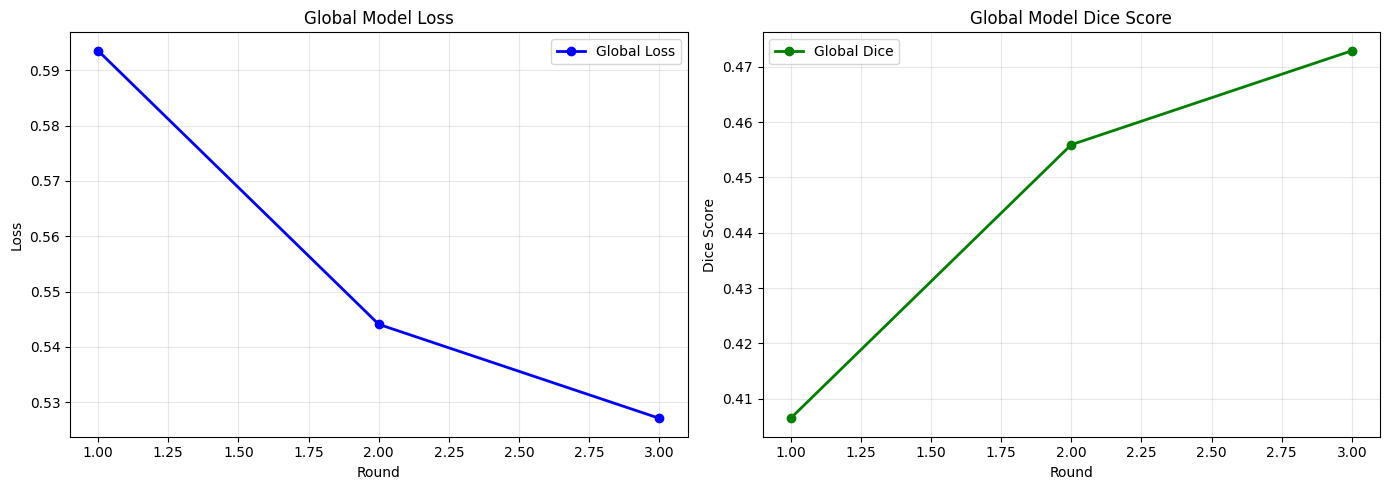

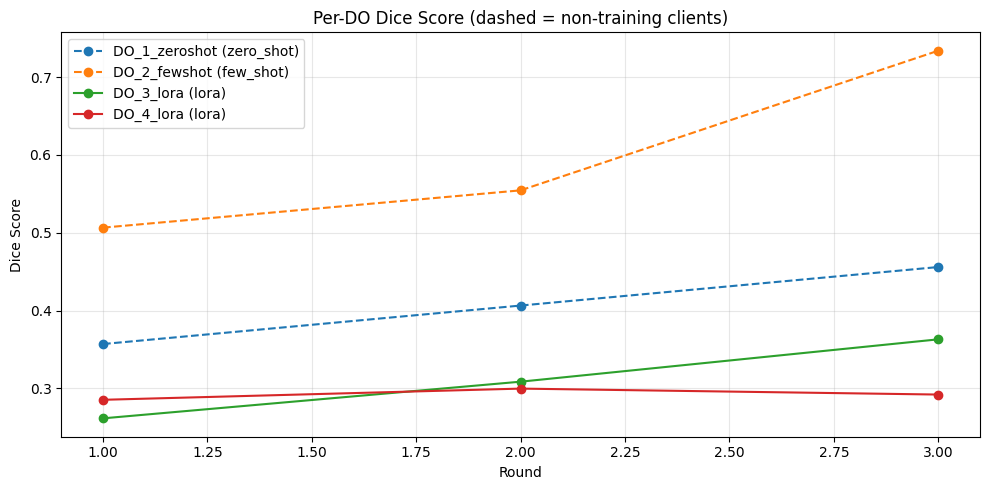

In [ ]:
# Cell 13: Plot Training Progress

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

rounds = range(1, NUM_ROUNDS + 1)

# Global model metrics
axes[0].plot(rounds, fl_history["global_loss"], 'b-o', label="Global Loss", linewidth=2)
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Loss")
axes[0].set_title("Global Model Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(rounds, fl_history["global_dice"], 'g-o', label="Global Dice", linewidth=2)
axes[1].set_xlabel("Round")
axes[1].set_ylabel("Dice Score")
axes[1].set_title("Global Model Dice Score")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Per-DO Dice scores
fig, ax = plt.subplots(figsize=(10, 5))

# Get DO names from the first round's metrics
do_names = list(fl_history["round_metrics"][0].keys())

for do_name in do_names:
    do_dice = [fl_history["round_metrics"][r][do_name]["dice"] for r in range(NUM_ROUNDS)]
    method = fl_history["round_metrics"][0][do_name]["method"]
    linestyle = '--' if method in ["zero_shot", "few_shot"] else '-'
    ax.plot(rounds, do_dice, linestyle, marker='o', label=f"{do_name} ({method})")

ax.set_xlabel("Round")
ax.set_ylabel("Dice Score")
ax.set_title("Per-DO Dice Score (dashed = non-training clients)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 13: Verify LoRA Effectiveness
# Compare initial model vs trained model on the SAME test set

print("="*80)
print("LORA EFFECTIVENESS CHECK")
print("="*80)

# 1. Create initial model (untrained LoRA)
print("\n1. Evaluating INITIAL model (untrained LoRA)...")
init_model = create_model(
    sam2_checkpoint=str(DEFAULT_SAM2_CHECKPOINT),
    sam2_config=DEFAULT_SAM2_CONFIG,
    img_size=IMG_SIZE,
    lora_rank=LORA_RANK,
    use_clip=USE_CLIP,
)

# Store initial weights for comparison
init_weights = get_weights(init_model)

# Evaluate initial model
init_model.eval()
init_dice_scores = []
with torch.no_grad():
    for batch in global_test_loader:
        image = batch["image"][0]
        mask_gt = batch["mask"][0, 0]
        try:
            predictions = init_model.zero_shot_segment(
                image=image,
                modality=MODALITY,
                class_names=["lung", "tissue"],
                similarity_threshold=0.1,
            )
            if predictions:
                pred_mask = list(predictions.values())[0]
                pred_binary = (pred_mask > 0.5).float().cpu()
                mask_binary = (mask_gt > 0.5).float()
                intersection = (pred_binary * mask_binary).sum()
                dice = (2.0 * intersection / (pred_binary.sum() + mask_binary.sum() + 1e-6)).item()
                init_dice_scores.append(dice)
        except:
            pass

init_avg_dice = np.mean(init_dice_scores) if init_dice_scores else 0.0
print(f"   Initial Model Dice: {init_avg_dice:.4f}")
del init_model

# 2. Create trained model (with global_weights from FL)
print("\n2. Evaluating TRAINED model (after FL with LoRA)...")
trained_model = create_model(
    sam2_checkpoint=str(DEFAULT_SAM2_CHECKPOINT),
    sam2_config=DEFAULT_SAM2_CONFIG,
    img_size=IMG_SIZE,
    lora_rank=LORA_RANK,
    use_clip=USE_CLIP,
)
if global_weights is not None:
    set_weights(trained_model, global_weights)

# Evaluate trained model
trained_model.eval()
trained_dice_scores = []
with torch.no_grad():
    for batch in global_test_loader:
        image = batch["image"][0]
        mask_gt = batch["mask"][0, 0]
        try:
            predictions = trained_model.zero_shot_segment(
                image=image,
                modality=MODALITY,
                class_names=["lung", "tissue"],
                similarity_threshold=0.1,
            )
            if predictions:
                pred_mask = list(predictions.values())[0]
                pred_binary = (pred_mask > 0.5).float().cpu()
                mask_binary = (mask_gt > 0.5).float()
                intersection = (pred_binary * mask_binary).sum()
                dice = (2.0 * intersection / (pred_binary.sum() + mask_binary.sum() + 1e-6)).item()
                trained_dice_scores.append(dice)
        except:
            pass

trained_avg_dice = np.mean(trained_dice_scores) if trained_dice_scores else 0.0
print(f"   Trained Model Dice: {trained_avg_dice:.4f}")

# 3. Check weight changes
print("\n3. Checking LoRA weight changes...")
if global_weights is not None:
    weight_diffs = []
    for i, (init_w, trained_w) in enumerate(zip(init_weights, global_weights)):
        diff = np.abs(init_w - trained_w).mean()
        weight_diffs.append(diff)
    
    avg_diff = np.mean(weight_diffs)
    max_diff = np.max(weight_diffs)
    print(f"   Average weight change: {avg_diff:.6f}")
    print(f"   Max weight change: {max_diff:.6f}")
    print(f"   Weights changed: {'YES' if avg_diff > 1e-8 else 'NO'}")
else:
    print("   No global_weights available (FL didn't run)")

# 4. Compare client types
print("\n4. Client Type Comparison (final round):")
if fl_history["round_metrics"]:
    final_metrics = fl_history["round_metrics"][-1]
    for do_name, metrics in final_metrics.items():
        print(f"   {do_name} ({metrics['method']}): Dice = {metrics['dice']:.4f}")

# 5. Summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
improvement = trained_avg_dice - init_avg_dice
print(f"Initial Model Dice:  {init_avg_dice:.4f}")
print(f"Trained Model Dice:  {trained_avg_dice:.4f}")
print(f"Improvement:         {improvement:+.4f} ({improvement/max(init_avg_dice, 0.001)*100:+.1f}%)")
print()
if improvement > 0.01:
    print("✅ LoRA training is EFFECTIVE - model improved after FL")
elif improvement > -0.01:
    print("⚠️  LoRA training shows MINIMAL effect - consider more rounds/data")
else:
    print("❌ LoRA training may not be working - check gradient flow")

del trained_model

2025-12-09 20:10:25.058 | INFO     | task:__init__:117 - Loading SAM-2 from /Users/khoaguin/Desktop/projects/OpenMined/partners/fl-sam2-lora/models/pretrained/sam2_hiera_tiny.pt...


LORA EFFECTIVENESS CHECK

1. Evaluating INITIAL model (untrained LoRA)...


2025-12-09 20:10:25.281 | INFO     | task:_init_sam2:150 - ✓ Loaded SAM2 using sam2 package
2025-12-09 20:10:25.282 | INFO     | task:__init__:124 - ✓ Froze SAM-2 backbone
2025-12-09 20:10:25.282 | INFO     | task:_apply_lora:154 - Adding LoRA adapters (r=8)...
2025-12-09 20:10:25.302 | INFO     | task:_apply_lora:176 - ✓ LoRA adapters: 238,488 params (0.91 MB)
2025-12-09 20:10:25.302 | INFO     | task:_init_clip:180 - Loading CLIP for zero-shot and few-shot...
2025-12-09 20:10:26.619 | INFO     | task:_init_clip:186 - ✓ CLIP loaded
2025-12-09 20:10:26.620 | INFO     | task:_init_training_decoder:201 - ✓ Using SAM2's native mask decoder for training (differentiable)
2025-12-09 20:10:26.622 | INFO     | task:print_trainable_parameters:1047 - Trainable: 238,488 (0.91 MB) | Total: 190,461,787 | Trainable %: 0.1252%
2025-12-09 20:10:28.240 | INFO     | task:__init__:117 - Loading SAM-2 from /Users/khoaguin/Desktop/projects/OpenMined/partners/fl-sam2-lora/models/pretrained/sam2_hiera_tiny.p

   Initial Model Dice: 0.3570

2. Evaluating TRAINED model (after FL with LoRA)...


2025-12-09 20:10:28.449 | INFO     | task:_init_sam2:150 - ✓ Loaded SAM2 using sam2 package
2025-12-09 20:10:28.450 | INFO     | task:__init__:124 - ✓ Froze SAM-2 backbone
2025-12-09 20:10:28.450 | INFO     | task:_apply_lora:154 - Adding LoRA adapters (r=8)...
2025-12-09 20:10:28.469 | INFO     | task:_apply_lora:176 - ✓ LoRA adapters: 238,488 params (0.91 MB)
2025-12-09 20:10:28.470 | INFO     | task:_init_clip:180 - Loading CLIP for zero-shot and few-shot...
2025-12-09 20:10:29.756 | INFO     | task:_init_clip:186 - ✓ CLIP loaded
2025-12-09 20:10:29.757 | INFO     | task:_init_training_decoder:201 - ✓ Using SAM2's native mask decoder for training (differentiable)
2025-12-09 20:10:29.759 | INFO     | task:print_trainable_parameters:1047 - Trainable: 238,488 (0.91 MB) | Total: 190,461,787 | Trainable %: 0.1252%


   Trained Model Dice: 0.4729

3. Checking LoRA weight changes...
   Average weight change: 0.018349
   Max weight change: 0.059077
   Weights changed: YES

4. Client Type Comparison (final round):
   DO_1_zeroshot (zero_shot): Dice = 0.4559
   DO_2_fewshot (few_shot): Dice = 0.7339
   DO_3_lora (lora): Dice = 0.3630
   DO_4_lora (lora): Dice = 0.2921

SUMMARY
Initial Model Dice:  0.3570
Trained Model Dice:  0.4729
Improvement:         +0.1159 (+32.5%)

✅ LoRA training is EFFECTIVE - model improved after FL


In [ ]:
# Cell 14: Summary Statistics

print("="*80)
print("FEDERATED LEARNING SUMMARY")
print("="*80)

print(f"\nConfiguration:")
print(f"  - Model: SAM2LoRA (from task.py)")
print(f"  - Rounds: {NUM_ROUNDS}")
print(f"  - Local Epochs: {LOCAL_EPOCHS}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - LoRA Rank: {LORA_RANK}")

print(f"\nData Owner Summary:")
final_round_metrics = fl_history["round_metrics"][-1]
for do_name, metrics in final_round_metrics.items():
    print(f"  {do_name}:")
    print(f"    Method: {metrics['method']}")
    print(f"    Final Dice: {metrics['dice']:.4f}")
    print(f"    Samples: {metrics['num_samples']}")

print(f"\nGlobal Model:")
print(f"  Initial Dice: {init_dice:.4f}")
print(f"  Final Dice: {fl_history['global_dice'][-1]:.4f}")
print(f"  Improvement: {fl_history['global_dice'][-1] - init_dice:+.4f}")

print(f"\nKey Observations:")
print(f"  - Only LoRA clients (DO_3, DO_4) contribute to weight aggregation")
print(f"  - Zero-shot uses CLIP for text-guided segmentation")
print(f"  - Few-shot uses memory bank with stored examples")
print(f"  - Global model improves via FedAvg of LoRA adapters")
print("="*80)

FEDERATED LEARNING SUMMARY

Configuration:
  - Model: SAM2LoRA (from task.py)
  - Rounds: 3
  - Local Epochs: 2
  - Learning Rate: 0.0001
  - LoRA Rank: 8

Data Owner Summary:
  DO_1_zeroshot:
    Method: zero_shot
    Final Dice: 0.4559
    Samples: 0
  DO_2_fewshot:
    Method: few_shot
    Final Dice: 0.7339
    Samples: 4
  DO_3_lora:
    Method: lora
    Final Dice: 0.3630
    Samples: 16
  DO_4_lora:
    Method: lora
    Final Dice: 0.2921
    Samples: 14

Global Model:
  Initial Dice: 0.2298
  Final Dice: 0.4729
  Improvement: +0.2432

Key Observations:
  - Only LoRA clients (DO_3, DO_4) contribute to weight aggregation
  - Zero-shot uses CLIP for text-guided segmentation
  - Few-shot uses memory bank with stored examples
  - Global model improves via FedAvg of LoRA adapters


In [ ]:
# Cell 16: Save Trained Model

import json

output_dir = PROJECT_ROOT / "outputs"
output_dir.mkdir(exist_ok=True)

# Create model with trained weights and save
if global_weights is not None:
    print("Creating model with trained LoRA weights...")
    final_model = create_model(
        sam2_checkpoint=str(DEFAULT_SAM2_CHECKPOINT),
        sam2_config=DEFAULT_SAM2_CONFIG,
        img_size=IMG_SIZE,
        lora_rank=LORA_RANK,
        use_clip=USE_CLIP,
    )
    set_weights(final_model, global_weights)
    
    # Save adapters using SAM2LoRA's built-in method
    save_path = output_dir / "fl_sam2lora_adapters.pth"
    final_model.save_adapters(str(save_path))
    print(f"✓ Model adapters saved to: {save_path}")
    
    del final_model
else:
    print("⚠️ No global_weights available - run FL training first (Cell 12)")

# Save FL history
history_path = output_dir / "fl_history.json"

# Convert to JSON-serializable format
history_json = {
    "global_loss": fl_history["global_loss"],
    "global_dice": fl_history["global_dice"],
    "config": {
        "num_rounds": NUM_ROUNDS,
        "local_epochs": LOCAL_EPOCHS,
        "learning_rate": LEARNING_RATE,
        "lora_rank": LORA_RANK,
    }
}

# Add per-round metrics (convert to serializable format)
history_json["round_metrics"] = []
for round_metrics in fl_history["round_metrics"]:
    round_data = {}
    for do_name, metrics in round_metrics.items():
        round_data[do_name] = {
            "method": metrics["method"],
            "dice": metrics["dice"],
            "loss": metrics["loss"],
            "num_samples": metrics["num_samples"],
        }
    history_json["round_metrics"].append(round_data)

with open(history_path, "w") as f:
    json.dump(history_json, f, indent=2)

print(f"✓ FL history saved to: {history_path}")

2025-12-09 20:10:31.388 | INFO     | task:__init__:117 - Loading SAM-2 from /Users/khoaguin/Desktop/projects/OpenMined/partners/fl-sam2-lora/models/pretrained/sam2_hiera_tiny.pt...


Creating model with trained LoRA weights...


2025-12-09 20:10:31.598 | INFO     | task:_init_sam2:150 - ✓ Loaded SAM2 using sam2 package
2025-12-09 20:10:31.599 | INFO     | task:__init__:124 - ✓ Froze SAM-2 backbone
2025-12-09 20:10:31.599 | INFO     | task:_apply_lora:154 - Adding LoRA adapters (r=8)...
2025-12-09 20:10:31.617 | INFO     | task:_apply_lora:176 - ✓ LoRA adapters: 238,488 params (0.91 MB)
2025-12-09 20:10:31.617 | INFO     | task:_init_clip:180 - Loading CLIP for zero-shot and few-shot...
2025-12-09 20:10:32.893 | INFO     | task:_init_clip:186 - ✓ CLIP loaded
2025-12-09 20:10:32.894 | INFO     | task:_init_training_decoder:201 - ✓ Using SAM2's native mask decoder for training (differentiable)
2025-12-09 20:10:32.896 | INFO     | task:print_trainable_parameters:1047 - Trainable: 238,488 (0.91 MB) | Total: 190,461,787 | Trainable %: 0.1252%
2025-12-09 20:10:32.930 | INFO     | task:save_adapters:1031 - ✓ Saved adapters to /Users/khoaguin/Desktop/projects/OpenMined/partners/fl-sam2-lora/outputs/fl_sam2lora_adapters

✓ Model adapters saved to: /Users/khoaguin/Desktop/projects/OpenMined/partners/fl-sam2-lora/outputs/fl_sam2lora_adapters.pth
✓ FL history saved to: /Users/khoaguin/Desktop/projects/OpenMined/partners/fl-sam2-lora/outputs/fl_history.json
